<h1><center>MLHEP 2019</center></h1>
<h2><center>Seminar: Unsupervised Learning</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Part 1: Clustering

## Data Preparation

In [2]:
from sklearn import datasets

n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(centers=3, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

In [3]:
X[:5]

array([[ -5.19811282,   0.64186932],
       [ -5.75229538,   0.41862711],
       [-10.84489837,  -7.55352273],
       [ -4.57098483,  -0.80101741],
       [ -3.51916215,   0.0393449 ]])

In [4]:
y[:5]

array([1, 1, 0, 1, 1])

In [5]:
def plot_clusters(X, y):

    # Create an figure with a custom size
    plt.figure(figsize=(9, 6))
    
    if y is not None:
        for cluster_label in np.unique(y):
            # Plot all objects with y == i (class 0)
            plt.scatter(X[y == cluster_label, 0],     # selects all objects with y == i and the 1st column of X
                        X[y == cluster_label, 1],     # selects all objects with y == i and the 2nd column of X
                        label=str(cluster_label))     # label for the plot legend
    else:
        plt.scatter(X[:, 0], X[:, 1], label='samples')

    plt.xlabel('X1', size=14) # set up X-axis label
    plt.ylabel('X2', size=14) # set up Y-axis label
    plt.xticks(size=14)
    plt.yticks(size=14)

    plt.legend(loc='best', fontsize=14) # create the plot legend and set up it position
    plt.grid(b=1) # create grid on the plot

    plt.show() # display the plot

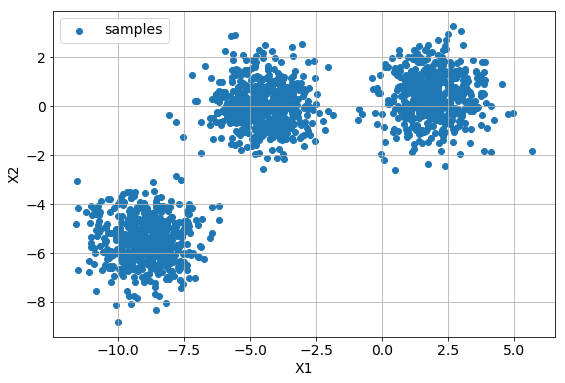

In [6]:
plot_clusters(X, y=None)

## Clustering: K-Means

Suppose we have $N$ samples and $K$ clusters. Each cluster is described by its center (centroid) with coordinates $\mu_{j}$. The centroids are estimated by minimizing **within-cluster distance criterion**:

$$
L = \sum_{i=1}^{N} \min_{\mu_{k}} \rho(x_{i}, \mu_{k}) \to \min_{\mu_{1}, ..., \mu_{K}}
$$

$$
\rho(x_{i}, \mu_{k}) = || x_{i} - \mu_{k} ||^{2}
$$

where $x_{i}$ is a sample coordinates, $\rho(x_{i}, \mu_{k})$ is distance between the $i$-th sample and the $k$-th cluster's centroid.

**K-Means algorithm:**

<center><img src="img/kmeans-alg.png" width=600></center>

<center><img src="img/kmean1.png"></center>

In [7]:
from sklearn.utils import resample


class MyKmeans(object):
    
    
    def __init__(self, n_clusters=2, max_iter=10, n_init=10):
        """
        K-Means clustering algorithms implementation.
        
        Parameters:
        -----------
        n_clusters: int
            Number of clusters.
        max_iters: int
            Number of iterations of the centroids search.
        n_init: int
            Number of different initializations of the centroids.
        """
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        
        
    
    def _predict_for_centers(self, cluster_centers, X):
        """
        Predict cluster labels based on their centroids.
        
        Parameters:
        -----------
        cluster_centers: numpy.array
            Array of the cluster centers.
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        labels: numpy.array
            Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
        """
        
        object_distances2 = []
        for one_cluster_center in cluster_centers:
            dist2 = ((X - one_cluster_center)**2).sum(axis=1)
            object_distances2.append(dist2)
        object_distances2 = np.array(object_distances2)
        labels = np.argmin(object_distances2, axis=0)
        
        return labels
    
    
    
    def _calculate_cluster_centers(self, X, y):
        """
        Estimate cluster centers based on samples in these clusters.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        y: numpy.array
            Cluster labels of the samples.
        
        Returns:
        --------
        cluster_centers: numpy.array
            Estimated cluster centers.
        """
        
        cluster_centers = []
        cluster_labels = np.unique(y)
        
        for one_cluster_label in cluster_labels:
            one_cluster_center = X[y == one_cluster_label].mean(axis=0)
            cluster_centers.append(one_cluster_center)
            
        return np.array(cluster_centers)
    
    
    
    def _calculate_cluster_metric(self, cluster_centers, X):
        """
        Calculate within-cluster distance criterion.
        
        Parameters:
        -----------
        cluster_centers: numpy.array
            Array of the cluster centers.
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        criterion: float
            The criterion value.
        """
        
        object_distances2 = []
        for one_cluster_center in cluster_centers:
            dist2 = ((X - one_cluster_center)**2).sum(axis=1)
            object_distances2.append(dist2)
        object_distances2 = np.array(object_distances2)
        min_dists2 = np.min(object_distances2, axis=0)
        criterion = min_dists2.mean()
        
        return criterion
    
    
    
    def _fit_one_init(self, X):
        """
        Run k-Means algorithm for randomly init cluster centers.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        cluster_centers: numpy.array
            Estimated cluster centers.
        metric: float
            Within-cluster distance criterion criterion value.
        """
        
        # Init cluster centers
        cluster_centers = resample(X, n_samples=self.n_clusters, random_state=None, replace=False)
        
        # Search for cluster centers
        for i in range(self.max_iter):
            labels = self._predict_for_centers(cluster_centers, X)
            cluster_centers = self._calculate_cluster_centers(X, labels)
            
        # Calculate within-cluster distance criterion
        metric = self._calculate_cluster_metric(cluster_centers, X)
            
        return cluster_centers, metric
    
        
        
    def fit(self, X):
        """
        Run k-Means algorithm.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        """
        
        self.best_cluster_centers = None
        self.best_metric = np.inf
        
        for i in range(self.n_init):
            
            # Run K-Means algorithms for randomly init cluster centers
            cluster_centers, metric = self._fit_one_init(X)
            
            # Save the best clusters
            if metric < self.best_metric:
                self.best_metric = metric
                self.best_cluster_centers = cluster_centers
                
    
    def predict(self, X):
        """
        Predict cluster labels.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        y: numpy.array
            Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
        """
        
        y = self._predict_for_centers(self.best_cluster_centers, X)
        
        return y

In [8]:
clusterer = MyKmeans(n_clusters=3, max_iter=20, n_init=10)
clusterer.fit(X)
y_pred = clusterer.predict(X)

In [9]:
y_pred[:10]

array([0, 0, 1, 0, 0, 2, 1, 1, 1, 2])

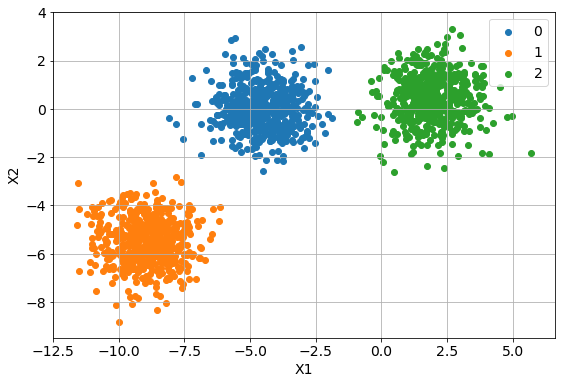

In [10]:
plot_clusters(X, y_pred)

## Metrics

**Silhouette Score:**

$$
s = \frac{b - a}{max(a, b)}
$$

- **a**: The mean distance between a sample and all other points in the same class.
- **b**: The mean distance between a sample and all other points in the next nearest cluster.


**Adjusted Rand Index (ARI):**

$$
ARI = \frac{RI - Expected\_RI}{max(RI) - Expected\_RI}
$$

$$
RI = \frac{a + b}{a + b + c + d}
$$


- a, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
- b, the number of pairs of elements in S that are in different subsets in X and in different subsets in Y
- c, the number of pairs of elements in S that are in the same subset in X and in different subsets in Y
- d, the number of pairs of elements in S that are in different subsets in X and in the same subset in Y

In [11]:
from sklearn import metrics

silhouette_score_values = []
adjusted_rand_score_values = []
within_cluster_dist_values = []
n_clusters = np.arange(2, 21)

for n in n_clusters:
    
    clusterer = MyKmeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)
    
    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)
    
    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)
    
    score3 = clusterer.best_metric
    within_cluster_dist_values.append(score3)

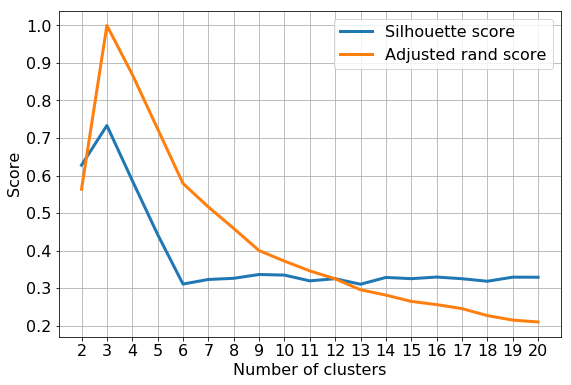

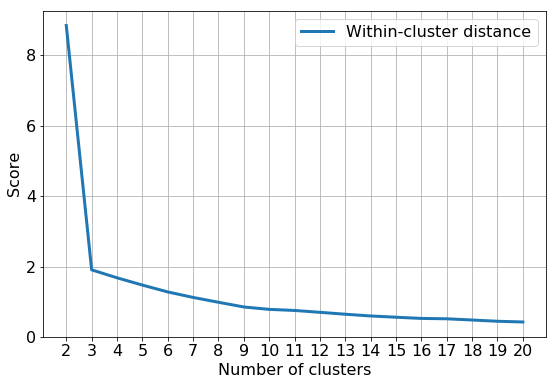

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()


plt.figure(figsize=(9, 6))
plt.plot(n_clusters, within_cluster_dist_values, linewidth=3, label='Within-cluster distance')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()

## Other Clustering Algorithms

Short overview of other clustering algorithms you can find in `scikit-learn` library [here](https://scikit-learn.org/stable/modules/clustering.html):

<center><img src="img/clusters.png"></center>

In [13]:
# Import clustering algorithms
from sklearn import cluster

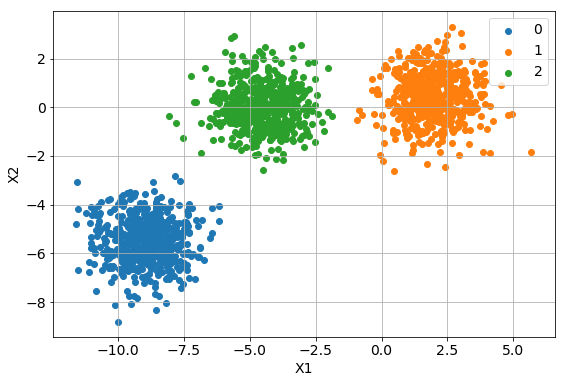

In [14]:
# MiniBatchKMeans

# Run clusterer
clusterer = cluster.MiniBatchKMeans(n_clusters=3, batch_size=100)
clusterer.fit(X)
y_pred = clusterer.predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

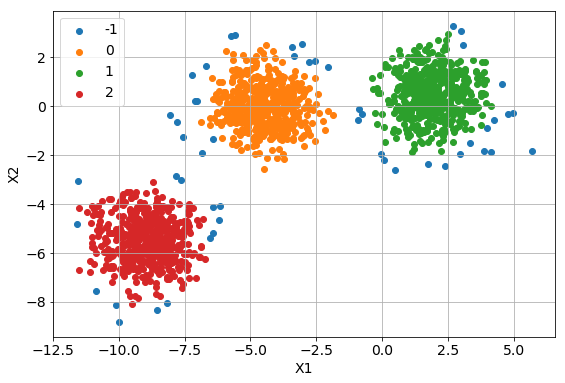

In [15]:
# DBSCAN

# Run clusterer
clusterer = cluster.DBSCAN(eps=0.5, min_samples=5)
y_pred = clusterer.fit_predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

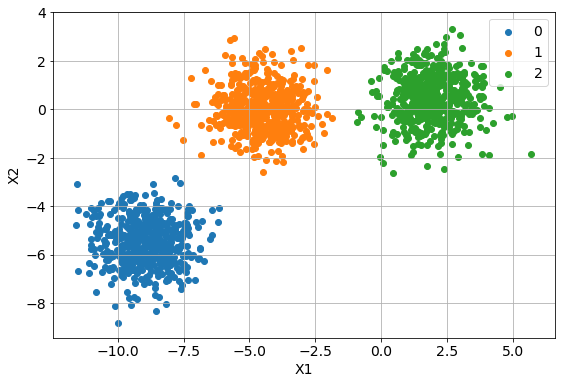

In [16]:
# AgglomerativeClustering

# Run clusterer
clusterer = cluster.AgglomerativeClustering(n_clusters=3)
y_pred = clusterer.fit_predict(X)

# Plot clustering results
plot_clusters(X, y_pred)

## Additional:

- Rerun cells above for other datasets. Explain the clustering results.
- Try different number of clusters and other options. How can you explain what you see?

---

---

---

# Part 2: Scaling

## Data Preparation

Multiply one of the sample features by a large number. 

In [17]:
X_scaled = X.copy()
X_scaled[:, 1] *= 100

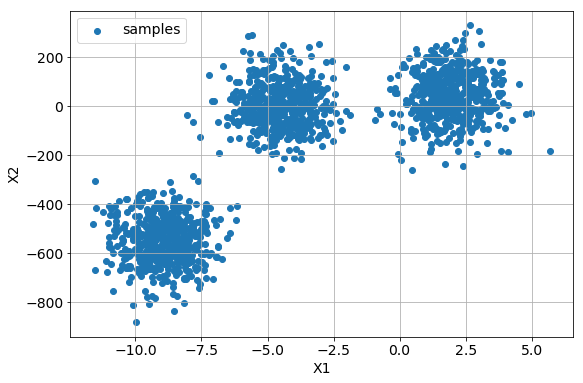

In [18]:
plot_clusters(X_scaled, None)

## Clustering without scaling

All clustering algorithms are based on distances between objects $\rho(x_{i}, x_{j})$. For an axample in 2D case:

$$
\rho(x_{i}, x_{j}) = \sqrt{ (x_{1i} - x_{1j})^{2} + (x_{2i} - x_{2j})^{2} }
$$

where $x_{1i}$ is the 1st input feature, $x_{2i}$ is the 2nd one.

Suppose, that the features have different scales:

$$
\frac{x_{2i}}{x_{1i}} = 1000
$$

Then

$$
\rho(x_{i}, x_{j}) = \sqrt{ (x_{1i} - x_{1j})^{2} + (x_{2i} - x_{2j})^{2} } \approx\sqrt{ (x_{2i} - x_{2j})^{2} }
$$

So, the 1st feature will not be taken into account by clustering algorithms.

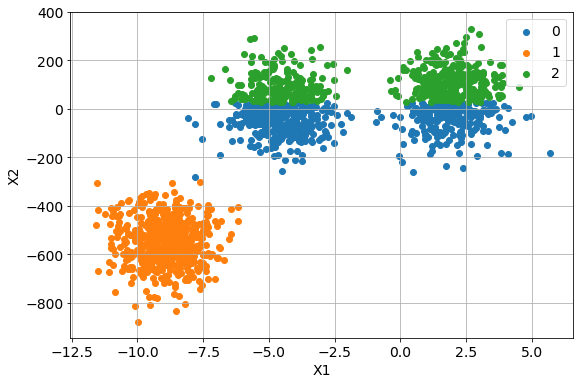

In [19]:
from sklearn import cluster

# Run clustering algorithm
clusterer = cluster.KMeans(n_clusters=3, n_init=10)
clusterer.fit(X_scaled)
y_pred = clusterer.predict(X_scaled)

# Show clustering results
plot_clusters(X_scaled, y_pred)

## Clustering with Standard Scaler

Satndard Scaler transforms feature $x$ to a new feature $x_{new}$ with zero mean and unit variance by the following way:

$$
x_{new} = \frac{ x - \mu }{ \sigma }
$$

where

$$
\mu = \frac{1}{N} \sum_{i=1}^{N}x_{i}
$$

$$
\sigma = \sqrt{ \frac{1}{N-1} \sum_{i=1}^{N} (x_{i} - \mu)^{2} }
$$

This transforms all input features to the same scale.

In [20]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_scaled)
X_scaled_ss = ss.transform(X_scaled)

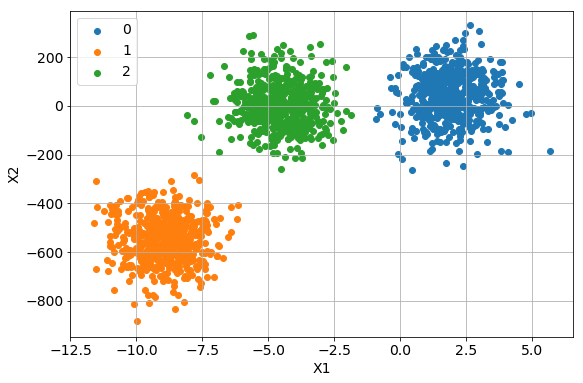

In [21]:
from sklearn import cluster

# Run clustering algorithm
clusterer = cluster.KMeans(n_clusters=3, n_init=10)
clusterer.fit(X_scaled_ss)
y_pred = clusterer.predict(X_scaled_ss)

# Show clustering results
plot_clusters(X_scaled, y_pred)

---

---

---

# Part 3: Principal Component Analysis (PCA)

## Data Preparation

In [22]:
from sklearn import datasets

# Generate 2D Gaussian distribution
n_samples = 2000
X, y = datasets.make_blobs(n_samples=n_samples, random_state=42, centers=[[0, 0]])

# Apply coordiantes transformation
transformation = [[0.6, 0.4], 
                  [0.4, 0.6]]
X_aniso = np.dot(X, transformation)

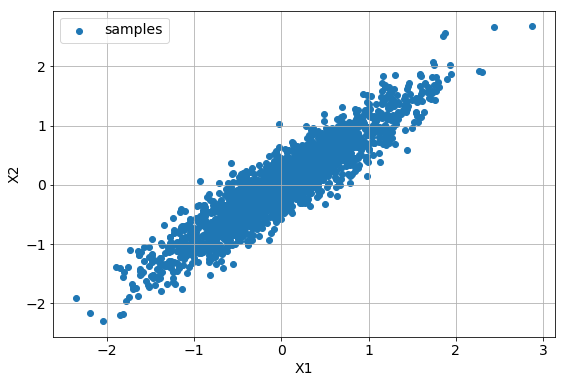

In [23]:
plot_clusters(X_aniso, None)

## Principal Component Analysis (PCA)


Find directions along which our datapoints have the greatest variance:


<center><img src='http://www.visiondummy.com/wp-content/uploads/2014/05/correlated_2d.png' width=400></center>


These directions are principal components. Principal components $a_{1},a_{2},...a_{D}\in\mathbb{R}^{D}$ are orthonormal: 

$$
\langle a_{i},a_{j}\rangle=\begin{cases}
1, & i=j\\
0 & i\ne j
\end{cases}
$$

## PCA algorithm (detailed):

### Step 1:
Calculate variance across a principal component $a$ assuming that $X$ is centralized:
$$
\begin{align} \sigma^2_a & = \frac{1}{n}\sum\limits_{i=1}^n(a^\top x_i - \mu)^2 \\
& = \frac{1}{n}\sum\limits_{i=1}^n(a^\top x_i - 0)^2 \\
& = \frac{1}{n}\sum\limits_{i=1}^n a^\top( x_i x_i^\top) a \\
& = a^\top \left(\frac{1}{n}\sum\limits_{i=1}^n x_i x_i^\top \right) a \\
& = a^\top X^\top X a \\
\end{align}
$$

### Step 2:
Find $a_1$ that maximizes the variance:

$$
\begin{equation}
\begin{cases}
a_1^\top X^\top X a_1 \rightarrow \max_{a_1} \\
a_1^\top a_1 = 1
\end{cases}
\end{equation}
$$

Lagrangian of optimization problem:
$$ \mathcal{L}(a_1, \nu) = a_1^\top X^\top X a_1 - \nu (a_1^\top a_1 - 1) \rightarrow max_{a_1, \nu}$$

Derivative w.r.t. $a_1$:
$$ \frac{\partial\mathcal{L}}{\partial a_1} = 2X^\top X a_1 - 2\nu a_1 = 0 $$

$$X^\top X a_1 = \nu a_1$$

---
#### Note:
So $a_1$ is selected from a set of eigenvectors of  $X^\top X$. But which one?

$$ a_1^\top X^\top X a_1 = \nu a_1^\top a_1 = \nu \rightarrow \max$$

That means:
* $\nu$ should be the greatest eigenvalue of matrix $X^\top X$, which is $\lambda_1$
* $a_1$ is eigenvector, correspondent to $\lambda_1$
---

### Step 3:

Similarly for $a_{2}$:

$$
\begin{equation}
\begin{cases}
a_2^\top X^\top X a_2 \rightarrow \max_{a_2} \\
a_2^\top a_2 = 1 \\
a_2^\top a_1 = 0
\end{cases}
\end{equation}
$$

...

## PCA algorithm (short)

1. Center (and scale) dataset
2. Calculate covariance matrix $С=X^\top X$
3. Find first $k$ eigenvalues and eigenvectors
$$A = 
\left[
  \begin{array}{cccc}
    \mid & \mid & & \mid\\
    a_{1} & a_{2} & \ldots & a_{k} \\
    \mid & \mid & & \mid 
  \end{array}
\right]
$$
4. Perform projection:
$$ Z = XA $$ 

In [24]:
# Import PCA
from sklearn.decomposition import PCA

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X_aniso)

# Apply PCA
X_aniso_pca = pca.transform(X_aniso)

In [25]:
X_aniso_pca

array([[ 2.00863372,  0.34270852],
       [ 2.25441368, -0.08924344],
       [-2.27556103, -0.03957319],
       ...,
       [-0.75223999, -0.32390193],
       [-0.40849702,  0.29572264],
       [-0.19811193, -0.02606302]])

In [26]:
pca_1 = PCA(n_components=1)
pca_1.fit(X_aniso)
X_aniso_pca_1 = pca_1.transform(X_aniso)

pca_2 = PCA(n_components=2)
pca_2.fit(X_aniso)
X_aniso_pca_2 = pca_2.transform(X_aniso)

No handles with labels found to put in legend.


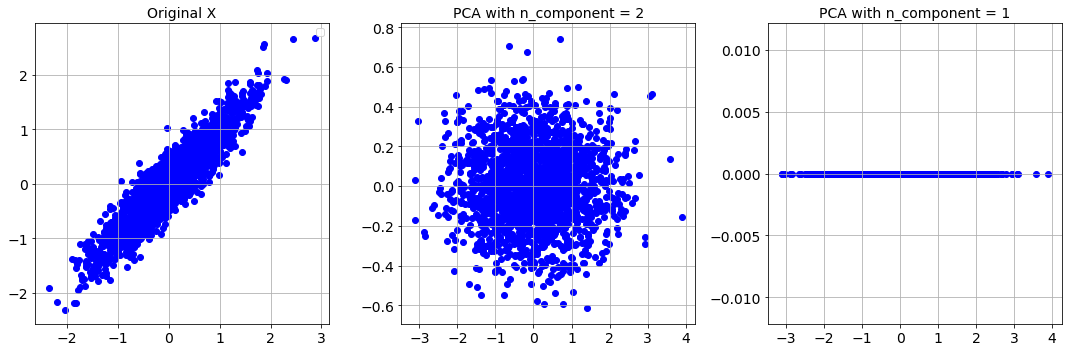

In [27]:
plt.figure(figsize=(15, 5))

# Plot original X with eigenvectors
plt.subplot(1, 3, 1)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], color='b')
plt.title("Original X", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(b=1)
plt.legend(loc='best')


# Plot for PCA with n_components=2
plt.subplot(1, 3, 2)
plt.scatter(X_aniso_pca_2[:, 0], X_aniso_pca_2[:, 1], color='b')
plt.title("PCA with n_component = 2", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(b=1)


# Plot for PCA with n_components=1
plt.subplot(1, 3, 3)
plt.scatter(X_aniso_pca_1[:, 0], [0]*len(X_aniso_pca_1), color='b')
plt.title("PCA with n_component = 1", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(b=1)


plt.tight_layout()
plt.show()

# Optional: Real Data Example

## Gender Recognition by Voice

This database was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range).

The following acoustic properties of each voice are measured and included within the CSV:

* meanfreq: mean frequency (in kHz)
* sd: standard deviation of frequency
* median: median frequency (in kHz)
* Q25: first quantile (in kHz)
* Q75: third quantile (in kHz)
* IQR: interquantile range (in kHz)
* skew: skewness (see note in specprop description)
* kurt: kurtosis (see note in specprop description)
* sp.ent: spectral entropy
* sfm: spectral flatness
* mode: mode frequency
* centroid: frequency centroid (see specprop)
* peakf: peak frequency (frequency with highest energy)
* meanfun: average of fundamental frequency measured across acoustic signal
* minfun: minimum fundamental frequency measured across acoustic signal
* maxfun: maximum fundamental frequency measured across acoustic signal
* meandom: average of dominant frequency measured across acoustic signal
* mindom: minimum of dominant frequency measured across acoustic signal
* maxdom: maximum of dominant frequency measured across acoustic signal
* dfrange: range of dominant frequency measured across acoustic signal
* modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
* label: male or female

In [28]:
# Read data sample
data = pd.read_csv("data/voice.csv")
print("DataFrame shape: ", data.shape)
data.head()

DataFrame shape:  (3168, 21)


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [29]:
# Get feature names
feature_names = data.columns.drop(['label'])
print("Feature names: ", feature_names)

Feature names:  Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx'],
      dtype='object')


In [30]:
# Prepare X and y
X = data[feature_names].values
y = 1. * (data['label'].values == 'male')

## Train / Test Split + Standardization

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardization
ss = StandardScaler()
ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Train Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
y_test_predict = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_test, y_test_predict)
auc = roc_auc_score(y_test, y_test_proba)
print("Accuracy: ", accuracy)
print("ROC AUC: ", auc)

Accuracy:  0.9709595959595959
ROC AUC:  0.9921436409104828


## Apply PCA

In [35]:
pca_accuracies = []
pca_aucs = []
pca_components = np.arange(1, 21)

for n_components in pca_components:
    
    # For each n_components run PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Fit a classifier
    clf = LogisticRegression()
    clf.fit(X_train_pca, y_train)
    
    # Make predictions
    y_test_predict = clf.predict(X_test_pca)
    y_test_proba = clf.predict_proba(X_test_pca)[:, 1]
    
    # Calculate quality metrics
    accuracy = accuracy_score(y_test, y_test_predict)
    pca_accuracies.append(accuracy)
    
    auc = roc_auc_score(y_test, y_test_proba)
    pca_aucs.append(auc)

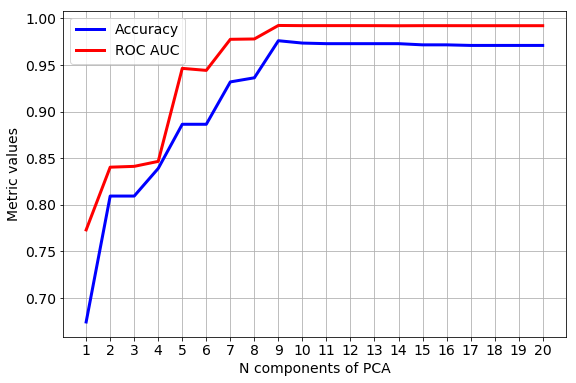

In [36]:
plt.figure(figsize=(9, 6))
plt.plot(pca_components, pca_accuracies, label='Accuracy', color='b', linewidth=3)
plt.plot(pca_components, pca_aucs, label='ROC AUC', color='r', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Metric values", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

## Explained variance

Explained variance for $a_i$ can be calculated as the following ratio:
$$
\frac{\lambda_{i}}{\sum_{d=1}^{D}\lambda_{d}}
$$

where $\lambda_{i}$ is an eigenvalue.

In [37]:
# Fit PCA
pca = PCA(n_components=20)
pca.fit(X_train)

# Take all eigenvalues (sorted)
eigenvalues = pca.explained_variance_

In [38]:
eigenvalues

array([9.09833165e+00, 2.41571497e+00, 2.14128851e+00, 1.48130678e+00,
       1.07218191e+00, 9.27294962e-01, 6.41454691e-01, 5.65292087e-01,
       4.84131552e-01, 3.69717115e-01, 3.29828857e-01, 1.83404987e-01,
       1.38007645e-01, 9.74084141e-02, 4.65047812e-02, 1.29118700e-02,
       7.85346432e-03, 3.88445168e-29, 1.27432635e-31, 2.28928798e-32])

In [39]:
pca_components = np.arange(1, 21)

# Calculate explained variance
explained_variance = eigenvalues / eigenvalues.sum()

# Calculate cumulative explained variance
cumsum_explained_variance = np.cumsum(explained_variance)

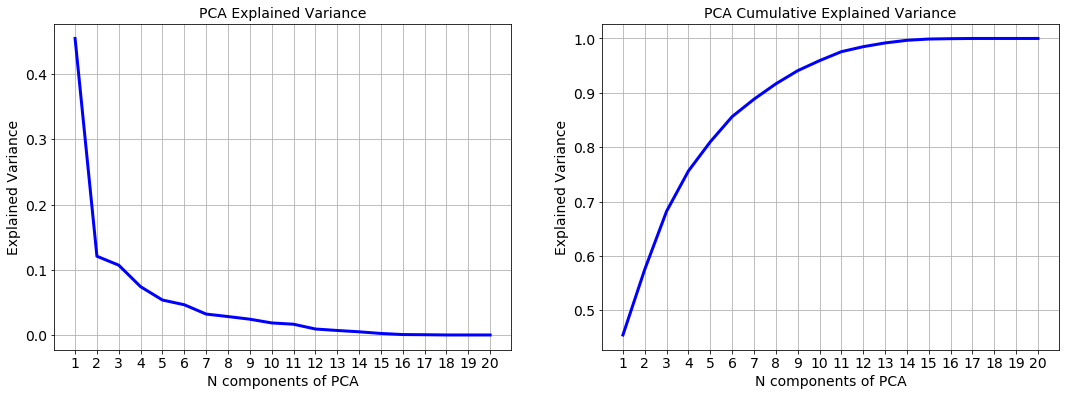

In [40]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(pca_components, explained_variance, color='b', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Explained Variance", size=14)
plt.title("PCA Explained Variance", size=14)
plt.grid(b=1)


plt.subplot(1, 2, 2)
plt.plot(pca_components, cumsum_explained_variance, color='b', linewidth=3)
plt.xticks(pca_components, size=14)
plt.xlabel("N components of PCA", size=14)
plt.yticks(size=14)
plt.ylabel("Explained Variance", size=14)
plt.title("PCA Cumulative Explained Variance", size=14)
plt.grid(b=1)


plt.show()